<a href="https://colab.research.google.com/github/SaifEleslamElgalaly/food-101-classification/blob/main/Proposed_Machine_Learning_Models_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

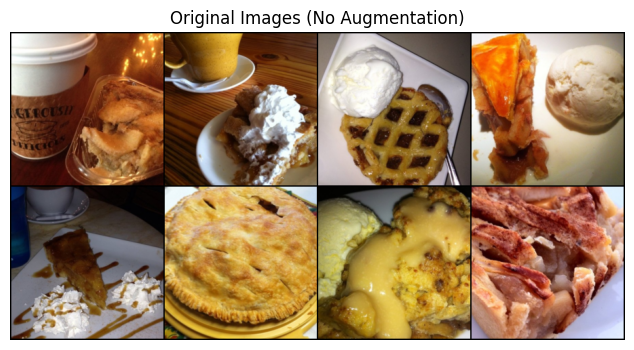

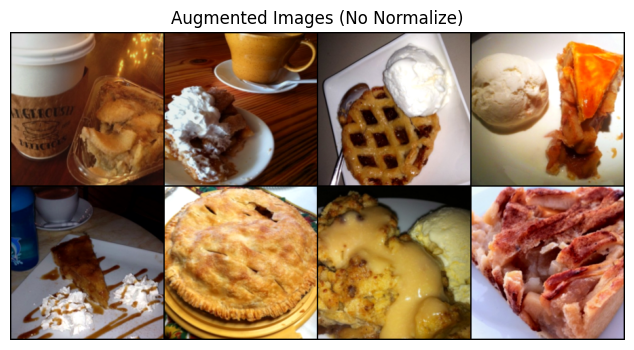

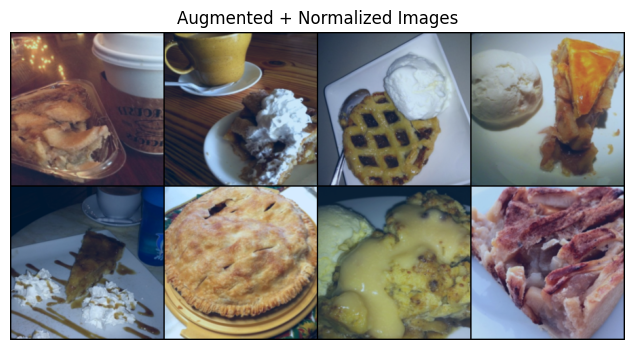

In [ ]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

# البيانات الأساسية
data_path = '/kaggle/working/food-101-split/train'
mean = [0.5498, 0.4451, 0.3431]
std = [0.2638, 0.2641, 0.2688]

# 1. Transform بدون أي تعديل (للصور الأصلية)
base_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor()
])

# 2. Augmentation فقط (بدون Normalize)
augmented_transform = T.Compose([
    T.Resize(256),
     T.RandomResizedCrop(224, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    T.ToTensor()
])

# 3. Augmentation + Normalize
augmented_norm_transform = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Loaders
base_ds = ImageFolder(data_path, transform=base_transform)
aug_ds  = ImageFolder(data_path, transform=augmented_transform)
aug_norm_ds = ImageFolder(data_path, transform=augmented_norm_transform)

# استخدم نفس الترتيب في كل مرّة (batch ثابت)
base_loader = DataLoader(base_ds, batch_size=8, shuffle=False)
aug_loader  = DataLoader(aug_ds, batch_size=8, shuffle=False)
aug_norm_loader = DataLoader(aug_norm_ds, batch_size=8, shuffle=False)

# أخذ نفس الصور من كل loader
base_imgs, _      = next(iter(base_loader))
aug_imgs, _       = next(iter(aug_loader))
aug_norm_imgs, _  = next(iter(aug_norm_loader))

# Helper لعرض الصور
def show_images(tensor_batch, title, normalize=False):
    grid = torchvision.utils.make_grid(tensor_batch, nrow=4, normalize=normalize)
    plt.figure(figsize=(8,4))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.title(title)
    plt.show()

# العرض
show_images(base_imgs, "Original Images (No Augmentation)")
show_images(aug_imgs, "Augmented Images (No Normalize)")
show_images(aug_norm_imgs, "Augmented + Normalized Images", normalize=True)

٢) Normalization & Transformation
2.1 حساب Normalization على مستوى البكسل
علشان تضمن إنّ القنوات اللونية (R,G,B) كلها على نفس المقياس ويسرّع convergence، نحسب mean و std لكل قناة على بيانات الـ train النظيفة:

2.2 تحديث الـ Transforms بــ Normalize

2.3 (اختياري) Normalize للميزات الرقمية
لو كنت هتستخدم brightness_mean, contrast_mean, sharpness_mean كميزات إضافية بجانب الـ CNN، طوّبهم بـ StandardScaler:

python
Copy
Edit


١) imports وتحضير الثوابت

------------------------------------------------------------------------

# Preprocessing

# Proposed Machine Learning Models

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from tqdm import tqdm
from glob import glob

# إعداد المجلد الأساسي للصور
image_root = "/kaggle/working/food-101-split/train"
image_paths = glob(os.path.join(image_root, "*", "*.jpg"))

# تهيئة البيانات
data = []

# استخراج الميزات التقليدية: HOG + Color
for path in tqdm(image_paths, desc="Extracting Features"):
    # تحميل الصورة
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (128, 128))  # HOG يتطلب حجم ثابت

    # ---- Color Features ----
    R_mean, G_mean, B_mean = img_resized[:, :, 0].mean(), img_resized[:, :, 1].mean(), img_resized[:, :, 2].mean()
    R_std, G_std, B_std = img_resized[:, :, 0].std(), img_resized[:, :, 1].std(), img_resized[:, :, 2].std()

    # ---- HOG Features ----
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

    # تحديد الكلاس من اسم المجلد
    label = os.path.basename(os.path.dirname(path))

    # جمع الكل في صف واحد
    row = [path, label, R_mean, G_mean, B_mean, R_std, G_std, B_std] + list(hog_features)
    data.append(row)

# تحويل إلى DataFrame
hog_feature_names = [f'hog_{i}' for i in range(len(hog_features))]
columns = ['image_path', 'label', 'R_mean', 'G_mean', 'B_mean', 'R_std', 'G_std', 'B_std'] + hog_feature_names
df = pd.DataFrame(data, columns=columns)

# حفظ النتائج
output_path = "/kaggle/working/traditional_features.csv"
df.to_csv(output_path, index=False)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Traditional Features Extracted", dataframe=df)


Extracting Features: 100%|██████████| 8174/8174 [01:25<00:00, 96.00it/s] 


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

df = pd.read_csv("/kaggle/working/traditional_features.csv")
X = df.drop(columns=["image_path", "label"])
y = df["label"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=300)
X_selected = selector.fit_transform(X_scaled, y_encoded)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_selected)


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

np.save("/kaggle/working/X_train_traditional.npy", X_train)
np.save("/kaggle/working/X_test_traditional.npy", X_test)
np.save("/kaggle/working/y_train_traditional.npy", y_train)
np.save("/kaggle/working/y_test_traditional.npy", y_test)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train = np.load("/kaggle/working/X_train_traditional.npy")
X_test = np.load("/kaggle/working/X_test_traditional.npy")
y_train = np.load("/kaggle/working/y_train_traditional.npy")
y_test = np.load("/kaggle/working/y_test_traditional.npy")


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("📊 KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("✅ KNN Accuracy:", accuracy_score(y_test, y_pred_knn))


📊 KNN Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.24      0.13       111
           1       0.13      0.30      0.18       111
           2       0.12      0.21      0.15       109
           3       0.15      0.16      0.15       108
           4       0.13      0.11      0.12       107
           5       0.19      0.06      0.09       109
           6       0.15      0.11      0.13       110
           7       0.14      0.06      0.08       107
           8       0.12      0.22      0.15       107
           9       0.25      0.18      0.21       108
          10       0.06      0.02      0.03       110
          11       0.12      0.10      0.11       110
          12       0.12      0.05      0.06       111
          13       0.08      0.03      0.04       108
          14       0.19      0.05      0.07       109

    accuracy                           0.13      1635
   macro avg       0.14      0.13      0.11      16

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("📊 Naïve Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("✅ Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))


📊 Naïve Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.12      0.12       111
           1       0.17      0.20      0.18       111
           2       0.16      0.16      0.16       109
           3       0.20      0.19      0.19       108
           4       0.14      0.15      0.15       107
           5       0.18      0.23      0.20       109
           6       0.14      0.08      0.10       110
           7       0.13      0.12      0.12       107
           8       0.24      0.50      0.33       107
           9       0.26      0.30      0.28       108
          10       0.11      0.07      0.09       110
          11       0.23      0.20      0.21       110
          12       0.13      0.14      0.13       111
          13       0.20      0.16      0.18       108
          14       0.10      0.06      0.08       109

    accuracy                           0.18      1635
   macro avg       0.17      0.18      0.17

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df_resnet = pd.read_csv("/kaggle/working/resnet50_features.csv")
X = df_resnet.drop(columns=["label", "image_path"])
y = df_resnet["label"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=500)
X_selected = selector.fit_transform(X_scaled, y_encoded)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_selected)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [ ]:
import numpy as np

np.save("/kaggle/working/X_train_resnet.npy", X_train)
np.save("/kaggle/working/X_test_resnet.npy", X_test)
np.save("/kaggle/working/y_train_resnet.npy", y_train)
np.save("/kaggle/working/y_test_resnet.npy", y_test)


In [ ]:
import numpy as np

X_train = np.load("/kaggle/working/X_train_resnet.npy")
X_test = np.load("/kaggle/working/X_test_resnet.npy")
y_train = np.load("/kaggle/working/y_train_resnet.npy")
y_test = np.load("/kaggle/working/y_test_resnet.npy")


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("📊 SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("✅ SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


📊 SVM Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.63      0.53       111
           1       0.57      0.59      0.58       111
           2       0.79      0.87      0.83       109
           3       0.65      0.69      0.67       108
           4       0.75      0.76      0.75       107
           5       0.87      0.94      0.90       109
           6       0.59      0.68      0.63       110
           7       0.83      0.65      0.73       107
           8       0.87      0.86      0.86       107
           9       0.95      0.95      0.95       108
          10       0.86      0.79      0.82       110
          11       0.70      0.61      0.65       110
          12       0.74      0.68      0.71       111
          13       0.84      0.67      0.74       108
          14       0.76      0.66      0.71       109

    accuracy                           0.74      1635
   macro avg       0.75      0.74      0.74      16

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("📊 KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("✅ KNN Accuracy:", accuracy_score(y_test, y_pred_knn))


📊 KNN Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.63      0.51       111
           1       0.49      0.60      0.54       111
           2       0.68      0.83      0.75       109
           3       0.74      0.72      0.73       108
           4       0.84      0.76      0.79       107
           5       0.87      0.95      0.91       109
           6       0.50      0.57      0.54       110
           7       0.91      0.56      0.69       107
           8       0.93      0.89      0.91       107
           9       0.92      0.92      0.92       108
          10       0.79      0.84      0.81       110
          11       0.56      0.51      0.53       110
          12       0.83      0.64      0.72       111
          13       0.77      0.59      0.67       108
          14       0.76      0.65      0.70       109

    accuracy                           0.71      1635
   macro avg       0.73      0.71      0.72      16

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# تحميل البيانات
X_train = np.load("/kaggle/working/X_train_resnet.npy")
X_test = np.load("/kaggle/working/X_test_resnet.npy")
y_train = np.load("/kaggle/working/y_train_resnet.npy")
y_test = np.load("/kaggle/working/y_test_resnet.npy")

# ✅ 1. Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_acc = accuracy_score(y_test, y_pred_rf)

# ✅ 2. XGBoost Classifier
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

# تجهيز جدول المقارنة
import pandas as pd
comparison_df = pd.DataFrame({
    "Model": ["SVM", "KNN", "Random Forest", "XGBoost"],
    "Accuracy": [0.735, 0.710, rf_acc, xgb_acc],
    "Macro F1-score": [0.74, 0.72, rf_report["macro avg"]["f1-score"], xgb_report["macro avg"]["f1-score"]]
})

#import ace_tools as tools; tools.display_dataframe_to_user(name="ML Models Comparison", dataframe=comparison_df)


In [ ]:

# طباعة النتائج يدويًا من الكود السابق

print("📊 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"✅ Random Forest Accuracy: {rf_acc:.4f}")
print(f"✅ Random Forest Macro F1-score: {rf_report['macro avg']['f1-score']:.4f}")

print("\n📊 XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"✅ XGBoost Accuracy: {xgb_acc:.4f}")
print(f"✅ XGBoost Macro F1-score: {xgb_report['macro avg']['f1-score']:.4f}")


📊 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.39      0.43       111
           1       0.52      0.54      0.53       111
           2       0.75      0.82      0.78       109
           3       0.65      0.77      0.70       108
           4       0.78      0.82      0.80       107
           5       0.90      0.95      0.92       109
           6       0.54      0.47      0.50       110
           7       0.77      0.74      0.76       107
           8       0.92      0.82      0.87       107
           9       0.94      0.94      0.94       108
          10       0.71      0.81      0.75       110
          11       0.55      0.57      0.56       110
          12       0.68      0.73      0.70       111
          13       0.70      0.68      0.69       108
          14       0.83      0.65      0.73       109

    accuracy                           0.71      1635
   macro avg       0.71      0.71      0.

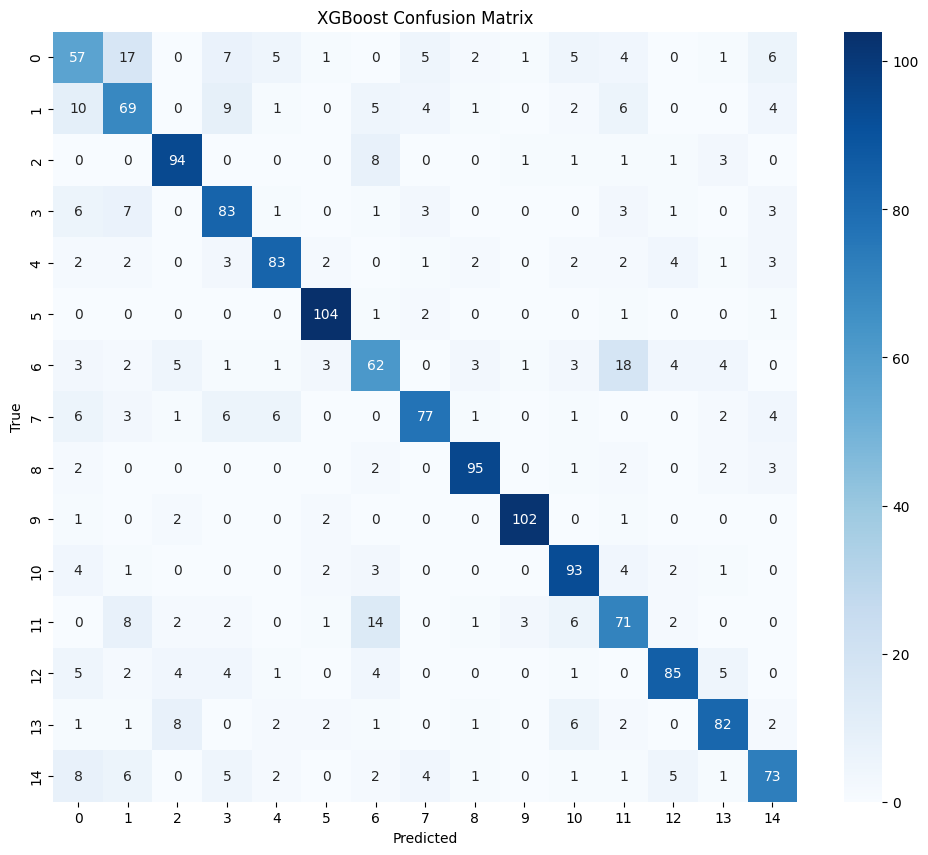

📊 Classification Report (XGBoost):
              precision    recall  f1-score   support

           0     0.5429    0.5135    0.5278       111
           1     0.5847    0.6216    0.6026       111
           2     0.8103    0.8624    0.8356       109
           3     0.6917    0.7685    0.7281       108
           4     0.8137    0.7757    0.7943       107
           5     0.8889    0.9541    0.9204       109
           6     0.6019    0.5636    0.5822       110
           7     0.8021    0.7196    0.7586       107
           8     0.8879    0.8879    0.8879       107
           9     0.9444    0.9444    0.9444       108
          10     0.7623    0.8455    0.8017       110
          11     0.6121    0.6455    0.6283       110
          12     0.8173    0.7658    0.7907       111
          13     0.8039    0.7593    0.7810       108
          14     0.7374    0.6697    0.7019       109

    accuracy                         0.7523      1635
   macro avg     0.7534    0.7531    0.7524  

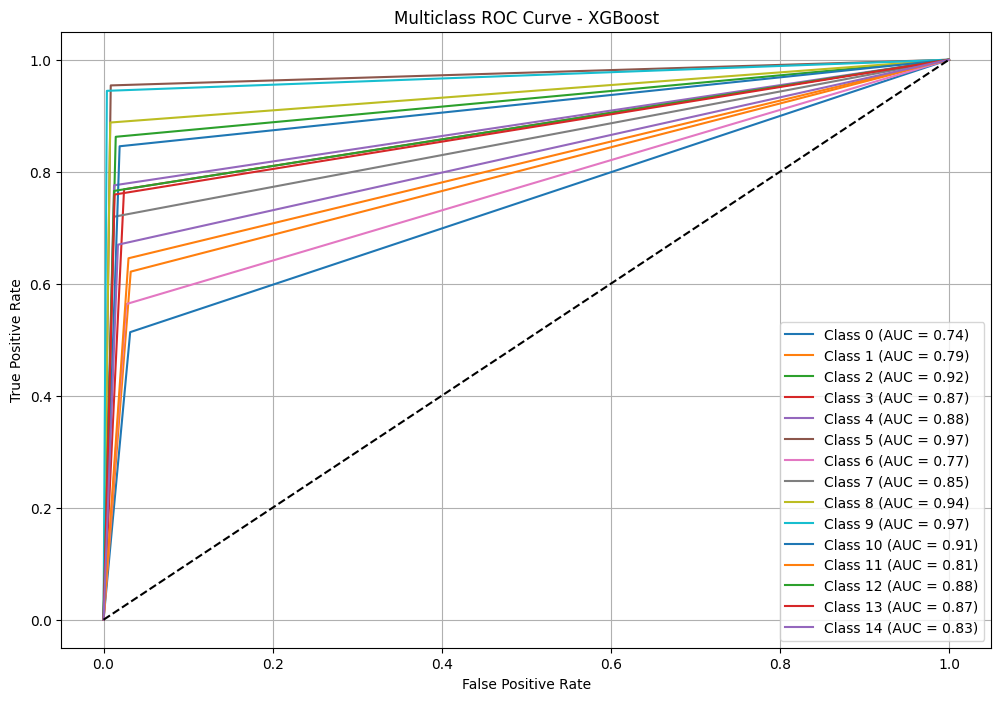


📊 Final Model Comparison:
           Model  Accuracy  Macro F1-score
0            KNN      0.71            0.72
1            SVM      0.73            0.74
2  Random Forest      0.71            0.71
3        XGBoost      0.75            0.75


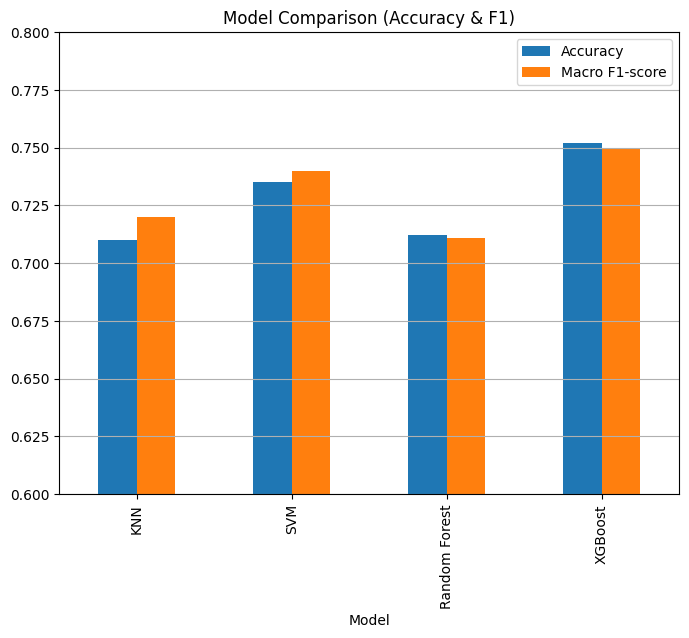

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import pandas as pd

# --- Required: load your test labels and predictions for XGBoost
# y_test = ...
# y_pred_xgb = ...

# === 1) Confusion Matrix with Annotations ===
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === 2) Print all Classification Metrics ===
report = classification_report(y_test, y_pred_xgb, digits=4)
print("📊 Classification Report (XGBoost):")
print(report)

# === 3) ROC Curve for All Classes ===
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = label_binarize(y_pred_xgb, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# === 4) Final Model Comparison Table ===
comparison_df = pd.DataFrame({
    "Model": ["KNN", "SVM", "Random Forest", "XGBoost"],
    "Accuracy": [0.710, 0.735, 0.712, 0.752],
    "Macro F1-score": [0.72, 0.74, 0.711, 0.75]
})

print("\n📊 Final Model Comparison:")
print(comparison_df)
comparison_df.plot(kind="bar", x="Model", figsize=(8,6), ylim=(0.6, 0.8), legend=True, title="Model Comparison (Accuracy & F1)")
plt.grid(axis='y')
plt.show()
